In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
'''
Coisas para ajeitar
'''

'\nCoisas para ajeitar\n'

In [3]:
# Main Constants

# Reference distance [m]
d0 = 1
# Constant for particular propagation enviroment
k = 1e-4
# Path Loss exponent
n = 4
# Total available bandwidth [Hz]
b_t = 100e6
# Constant for noise power [W/Hz]
k0 = 1e-20
# Side of a total area [m]
cov_side = 1e3

seeds = 1000

np.random.seed(14)

In [4]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [5]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [6]:
# Functions related to nodes positioning and distance

def random_position(cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    '''
    
    x_pos = np.random.rand() * cov_side
    y_pos = np.random.rand() * cov_side
    
    return np.array([x_pos, y_pos])


def ap_position(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')

        
def distance(ue_pos, ap_pos, ref_distance=d0):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''
    
    dis = np.sqrt((ue_pos[0] - ap_pos[0])**2
                  + (ue_pos[1] - ap_pos[1])**2)
    
    if dis >= ref_distance:
        return dis
    else:
        return ref_distance

In [7]:
# Functions related to channel modeling

def path_loss(distance2AP, ref_distance=d0):
    ''' 
    Returns the path loss [in dB] between an UE and an AP as defined by [emil2021].
    
    Parameters
    ----------
    distance2AP : int, float
        The distance between UE and AP.
    ref_distance : int, float
        The reference distance from which the path loss is calculated.
    '''
    
    gain = -36.7 -10*n*np.log10(distance2AP)
    
    return gain

def shadowing(std):
    '''
    Returns the shadowing [in dB], which is a zero-mean lognormal distribution.
    
    Parameters
    ----------
    std : int, float
        The standard deviation of distribution. 
    '''
    
    return std*np.random.randn()

def channel(path_loss, shadowing, noise_g):
    '''
    Returns the channel [in linear] between an UE and an AP.
    
    Parameters
    ----------
    path_loss : int, float
        The path loss (or channel gain) [in dB] between an UE and an AP. 
    shadowing : int, float
        The shadowing effect [in dB] between an UE and an AP.
    noise_g : int, float
        The noise gain [in W] of system.
    '''
    
    return db2lin(path_loss + shadowing) / noise_g

def noise_g(noise_constant, bandwidth, noise_f=9):
    '''
    Returns the noise gain [in linear] in a system according to the badwidth that is being used.
   
    Parameters
    ----------
    noise_constant : int, float
        The noise constant [in W/Hz]  defined as k0 in the [Introduction to wireless ...].
    bandwidth : int, float
        The bandwidth [in Hz] available for the system.
    noise_f: int, flot
        The ... (default is 9 [dB])
    '''
    
    return noise_constant * bandwidth * db2lin(noise_f)

In [8]:
# Functions related to power

def received_power(t_power, channel):
    '''
    Returns the received power [in W] by an AP transmitted by an UE considering the channel between them
    
    Parameters
    ----------
    t_power : int, float
        Power transmitted [in W] by UE.
    channel : int, float
        Channel between UE and AP [in linear].
    '''
    
    return t_power * channel

def noise_p(noise_constant, bandwidth):
    '''
    Returns the noise power [in W] in a system according to the badwidth that is being used.
   
    Parameters
    ----------
    noise_constant : int, float
        The noise constant [in W/Hz]  defined as k0 in the [Introduction to wireless ...].
    bandwidth : int, float
        The bandwidth [in Hz] available for the system.
    '''
    
    return noise_constant * bandwidth

In [9]:
def sinr(k, t_power, channel_matrix, noise_p):
    '''
    Returns the signal-to-interference-plus-noise [in linear] ratio in a cell-free scenario according to [Emil2021]
    
    Parameters
    ----------
    k : int
        The user whose the sinr is being calculated.
    t_power : int, float
        The power [in W] of the user.
    channel_matrix : numpy matrix
        The matrix containing the channels [in linear] of every link in the system, the matrix shape must be
        num_ue x num_ap.
    noise_p : int, float
        The system noise power [in W].
    '''
    
    sinr = np.zeros(len(channel_matrix))
    comb_vector = np.zeros(len(channel_matrix))
    
    # Does the sum of the products between a matrix and its hermetian for all users but the one in interest.
    channel_sum = 0
    
    for ue in range(len(channel_matrix)):
        channel_sum += channel_matrix[ue] @ channel_matrix[ue].T

    # channel_sum -= channel_matrix[k] @ channel_matrix[k].T
    
    for ue in range(len(channel_matrix)):
        # The combination vector
        comb_vector = ((t_power[ue] * (channel_sum - channel_matrix[ue] @ channel_matrix[ue].T) + noise_p**2) 
                       * channel_matrix[ue])

        interest = np.abs(comb_vector.T @ channel_matrix[ue])**2 * t_power[ue]
        interfering = ((t_power[ue] * (channel_sum - channel_matrix[ue] @ channel_matrix[ue].T) + noise_p**2) 
                      * comb_vector.T @ comb_vector)
        
        sinr[ue] = interest/interfering
    
    return sinr

In [10]:
def capacity(bandwidth, sinr):
    '''
    Returns te capacity [in Mbps], the data rate of system.

    Parameters
    ----------
    bandwidth : int, float
        The bandwidth [in Hz] available for the system.
    sinr : int, float
        The SINR [in linear] of the link in question.
    '''
    
    return (bandwidth * np.log2(1 + sinr)) / 1e6

In [19]:
def fractional_power_control(gain_matrix, max_power, compensation_factor=0.8, target_power=-35):

    power_vector = np.zeros(gain_matrix.shape[0])
    
    for i in range(gain_matrix.shape[0]):

        # zeta as defined in article (how to cite?)
        zeta = np.sqrt(sum(gain_matrix[i]))
        new_transmitted_power = db2lin(target_power) * zeta**(-compensation_factor)

        if new_transmitted_power < max_power:
            power_vector[i] = new_transmitted_power
        else:
            power_vector[i] = max_power
            
    return power_vector

In [ ]:
def stepwise_removal():
    matrix_F = np.zeros((self.UE_quantity, self.UE_quantity))
        gain_array = np.zeros(self.UE_quantity)

        for UE in range(self.UE_quantity):
            gain_array[UE] = self.gain_matrix[UE,
                                              self.AP_list.index(self.UE_list[UE].linkedAP)]

        for row in range(self.UE_quantity):
            matrix_F[row] = gain_array

        for UE in range(self.UE_quantity):
            matrix_F[UE] = matrix_F[UE] / gain_array[UE]

        matrix_F[np.where(matrix_F==1)] = 0

        K = self.UE_quantity

        while True:

            ''' The maximal achievable SINR'''        

            # The maximal achievable SINR is the inverse of the maximal eigenvalue of F.

            eigenvalues_matrix = np.linalg.eig(matrix_F)[0]

            maximal_achievable_SINR = 1 / eigenvalues_matrix.max()

            ''' Matrix D as defined in Han Liu '''

            # D is a diagonal matrix which the main diagonal is the target SINR for each user.
            # Here the target SINR is constant for all users

            target_SINR = db2lin(-5) 
            target_SINR_array = np.zeros(K)

            target_SINR_array[np.where(target_SINR_array==0)] = target_SINR
            matrix_D = np.diag(target_SINR_array)


            ''' Matrix u as defined in Han Liu '''

            # u is a square matrix that relates the target SINR, the thermal noise and the channel gain

            matrix_u = np.zeros(K)
            thermal_noise = self.noise_power

            for j in range(K):    
                matrix_u[j] = ( target_SINR_array[j] * thermal_noise ) / gain_array[j] 


            ''' Defines P if the condition is satisfied according to Han Liu '''



            # P is the optimal power array for the system
            if maximal_achievable_SINR >= target_SINR: 

                    P = np.dot(np.linalg.inv(np.identity(K) - np.dot(matrix_D, matrix_F)), matrix_u)
                    break

            else:

                # print(matrix_F)
                if K > 2 :

                    max_value = float('-inf')
                    max_j = 0

                    for j in range(K):

                        soma = sum(matrix_F[j]) + sum(np.transpose(matrix_F)[j])

                        if soma > max_value:
                            max_value = soma
                            max_j = j

                    matrix_F = np.delete(matrix_F, j, 0)
                    matrix_F = np.delete(matrix_F, j, 1)
                    self.UE_list.remove(self.UE_list[j])

                    K -= 1

                else:
                    for UE in range(K):
                        self.UE_list[UE].transmitted_power = 0
                    P = np.zeros(K)
                    break


        for power in range(K):
            #print(P)
            if len(P) > 0:

                #print(power, self.UE_list, P)
                self.UE_list[power].transmitted_power = P[power]

In [26]:
num_ue = 10
total_sinr_fpc = np.zeros((num_ue, seeds))
total_sinr_mp = np.zeros((num_ue, seeds))
max_power = 1

for seed in range(seeds):

    ue_pos_vector = []

    for UE in range(num_ue):
        ue_pos_vector.append(random_position(cov_side))

    ap_pos = ap_position(16, cov_side)


    # Noise constants
    noise_gain = noise_g(k0, b_t, noise_f=5)
    noise_power = noise_p(k0, b_t)


    # The matrixes
    distance_matrix = np.zeros((num_ue, 
                                len(ap_pos)))
    path_loss_matrix = np.zeros((num_ue, 
                                 len(ap_pos)))
    shadowing_matrix = np.zeros((num_ue, 
                                 len(ap_pos)))
    channel_matrix = np.zeros((num_ue, 
                               len(ap_pos)))


    for i in range(num_ue):
        for j in range(len(ap_pos)):

            distance_matrix[i, j] = distance(ue_pos_vector[i], 
                                             ap_pos[j])

            shadowing_matrix[i, j] = shadowing(2) # std = 2

    path_loss_matrix = path_loss(distance_matrix, d0)

    channel_matrix = channel(path_loss_matrix,
                             shadowing_matrix,
                             noise_gain)
        
    power_vector_mp = np.ones(num_ue)
    power_vector_fpc = fractional_power_control(channel_matrix,
                                                max_power)
    
    for UE in range(num_ue):
        total_sinr_mp[:, seed] = sinr(num_ue, power_vector_mp, channel_matrix, noise_gain)
        total_sinr_fpc[:, seed] = sinr(num_ue, power_vector_fpc, channel_matrix, noise_gain)
        

In [21]:
mean_sinr_mp = lin2db(np.mean(total_sinr_mp, axis=0))
ac_sinr_mp = lin2db(total_sinr_mp)

mean_sinr_fpc = lin2db(np.mean(total_sinr_fpc, axis=0))
ac_sinr_fpc = lin2db(total_sinr_fpc)

In [22]:
mean_capacity_mp = capacity(b_t, db2lin(mean_sinr_mp))
ac_capacity_mp = capacity(b_t, db2lin(ac_sinr_mp))

mean_capacity_fpc = capacity(b_t, db2lin(mean_sinr_fpc))
ac_capacity_fpc = capacity(b_t, db2lin(ac_sinr_fpc))

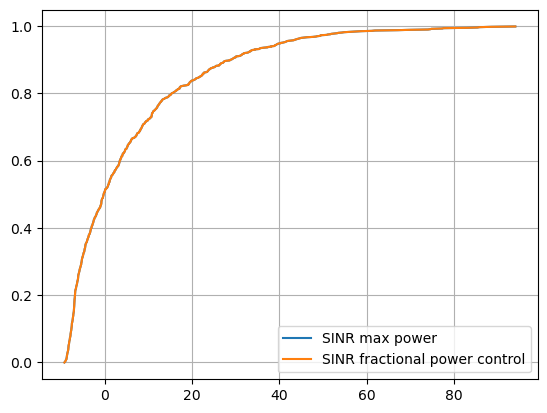

In [23]:
sinr_mp_CDF = eCDF(mean_sinr_mp.flatten())
plt.plot(sinr_mp_CDF[0], sinr_mp_CDF[1], label = 'SINR max power')

sinr_fpc_CDF = eCDF(mean_sinr_fpc.flatten())
plt.plot(sinr_fpc_CDF[0], sinr_fpc_CDF[1], label = 'SINR fractional power control')

plt.legend()
plt.grid()

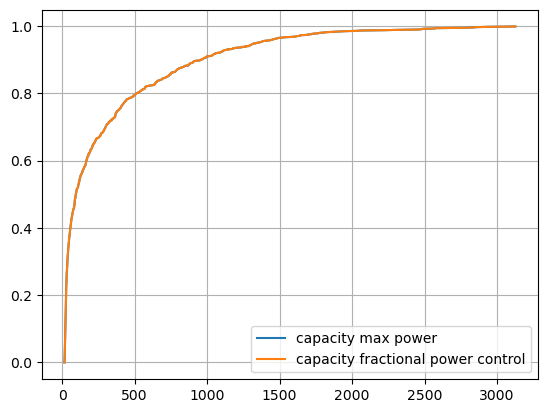

In [24]:
capacity_mp_CDF = eCDF(mean_capacity_mp.flatten())
plt.plot(capacity_mp_CDF[0], capacity_mp_CDF[1], label = 'capacity max power')

capacity_fpc_CDF = eCDF(mean_capacity_fpc.flatten())
plt.plot(capacity_fpc_CDF[0], capacity_fpc_CDF[1], label = 'capacity fractional power control')

plt.legend()
plt.grid()

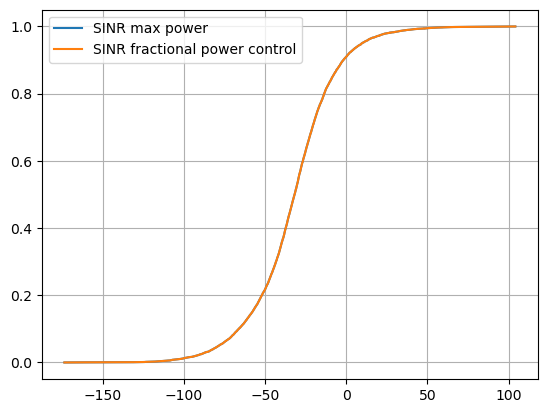

In [27]:
ac_sinr_mp_CDF = eCDF(ac_sinr_mp.flatten())
plt.plot(ac_sinr_mp_CDF[0], ac_sinr_mp_CDF[1], label = 'SINR max power')

ac_sinr_fpc_CDF = eCDF(ac_sinr_fpc.flatten())
plt.plot(ac_sinr_fpc_CDF[0], ac_sinr_fpc_CDF[1], label = 'SINR fractional power control')

plt.legend()
plt.grid()

In [18]:
capacity_CDF = eCDF(c2.flatten())
plt.plot(capacity_CDF[0], capacity_CDF[1], label = 'capacity')

plt.legend()
plt.grid()